In [ ]:
""" 
# Data analysis for the entire year, or all the months selected. 
Run first the data-cleaning script, unless you have already clean data.
If the cleaned data are already loaded into global variables, the script
will recognize automatically.
"""

" Import needed packages"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

""" Select the data to elaborate and some options """ 

" List the year and month of the data that you want to analyze as YYYYMM "
dates = ["202204","202205","202206","202207","202208","202209"
         ,"202210","202211","202212","202301","202302","202303",]
clean_folder = "" # path to the folder where the cleaned data is saved.
                  # Default is the working folder as "".
save_folder = ""  # path to the folder where the graph will be saved.
                  # Default is the working folder as "".

" Outputs "
monthly_summary_table = False # should the script print the summary_table
                              # for each month? Default is False.
monthly_histogram = False # should the script print the histogram of 
                          # ride_duration for each month? Default is False.
histogram_max = [50000000] # X extension of the histogram(s) in minutes.
    # can take a list so to print multiple histograms with different zoom levels
    # Default is a very large number so to print the entire histogram
    

""" The computation part of the script starts from here """

# iterates over all the selected files
for first_month, date in enumerate(dates):

    # Imports the cvs data of the month as the "data" variable
    if "data_" + date in globals(): # checks if the data is not already loaded
        data = globals()["data_" + date]
        print("Retrieving data from already loaded variable.")
    elif get_ipython() and ('_stored_items' in dir(get_ipython())):
        # If running in Jupyter environment, tries to retrieve the data
        # from a different kernel
        try:
            # retrieve data from a different kernel
            get_ipython().run_line_magic('store', '-r {}'.format(data_name))
            data = globals()[data_name]
            print("Retrieving data from another kernel.")
        except:
            print("Data not found in other kernel.")
    else:
        path = clean_folder + "cleaned_" + date + ".csv"
        data = pd.read_csv(path) # converts the .cvs file to pandas dataframe
        print("Retrieving data from folder.")

    # Extracts year and month for writing the correct header for the graphs
    year = date[0:4]                          # extracts the year
    month_number = int(date[4:6])             # extracts the month number
    month = calendar.month_name[month_number] # converts month number to name
    date_header = ", " + year + " " + month   # date header for the graphs
    
    # prints the month and year of the file it is extracting
    print(date_header[1:] + " ###############################################")

    # Turns the entries of the columns "started_at" and "ended_at" 
    # into datetime format and the "ride_length" column into timedelta format
    if "data_" + date not in globals(): 
        data["started_at"] = pd.to_datetime(data["started_at"])
        data["ended_at"] = pd.to_datetime(data["ended_at"])
        data["ride_length"] = pd.to_timedelta(data["ride_length"])
    
    """ Histogram part, ride duration vs number of rides """
    if monthly_histogram is True: # option to print the monthly histogram
        
        # prepares the data for the histogram
        data_cut = data.loc[:,["member_casual","ride_length"]]
        data_casual = data_cut.groupby("member_casual").get_group("casual")
        data_member = data_cut.groupby("member_casual").get_group("member")
        data_casual.loc[:,"ride_length"] = (data_casual["ride_length"].dt.seconds/60
                            + data_casual["ride_length"].dt.days/24/60) #minutes
        data_member.loc[:,"ride_length"] = (data_member["ride_length"].dt.seconds/60
                                            + data_member["ride_length"].dt.days/24/60)#minutes
        # prints the histogram(s)
        for range_max in histogram_max: # max extension(s) of the histogram
            # plots the histogram
            data_casual.ride_length[data_casual.ride_length < range_max].plot(
                kind="hist", bins = 50, log=True, alpha=0.5, label="casual")
            data_member.ride_length[data_member.ride_length < range_max].plot(
                kind="hist", bins = 50, log=True, alpha=0.5, label="member",
                title="frequency of ride duration" + date_header)
            plt.legend(loc="upper right")
            plt.xlabel("Ride duration (minutes)")
            plt.show()
    
    """ Summary Table part: MAX, MIN, Count, MODE, MEAN, Total rides duration """
    print("Computing Summary Table for member_vs_casual, ride duration" + date_header)
    summary_table = pd.pivot_table(data
                   , index = "member_casual"
                  , values = "ride_length"
                  , aggfunc = [max, min, len, lambda x: x.mode()[0]]
                  , margins = True)
    pivot_mean = pd.pivot_table(data
                   , index = "member_casual"
                  , values = "ride_length"
                  , aggfunc = lambda x: x.mean().round(freq='s')
                  , margins = True)
    pivot_sum = pd.pivot_table(data
                   , index = "member_casual"
                  , values = "ride_length"
                  , aggfunc = sum
                  , margins = False)
    pivot_sum.loc["All"] = pivot_sum.loc["casual"] + pivot_sum.loc["member"]
    summary_table = summary_table.rename( # renaming columns
        columns={'<lambda>': 'mode', "len" : 'count'}
        )
    summary_table["mean"]= pivot_mean['ride_length'] # add MEAN to summary_table
    summary_table["sum"]= pivot_sum # add Total to summary_table
    if monthly_summary_table is True: # option to print summary_table 
        print(summary_table)

    # initializes the tables for the yearly aggregated data:
    # MAX, MIN, Count, MODE, MEAN, Total of ride duration
    if first_month == 0: # initialization happens at the first month
        
        year_max = summary_table["max"] # MAX ride duration for the first month
        year_max = year_max.rename( # sets the first month name as the column name
                                    columns={'ride_length': month})   
        
        year_min = summary_table["min"] # MIN ride duration for the first month
        year_min = year_min.rename( # sets the first month name as the column name
                                    columns={'ride_length': month})
        
        year_count = summary_table["count"] # Count of ride duration for the first month
        year_count = year_count.rename( # sets the first month name as the column name
                                        columns={'ride_length': month}) 
        
        year_mode = summary_table["mode"] # MODE of ride duration for the first month
        year_mode = year_mode.rename( # sets the first month name as the column name
                                        columns={'ride_length': month}) 
        
        year_mean = pd.DataFrame(summary_table["mean"]) # MEAN ride duration for the first month
        year_mean = year_mean.rename( # sets the first month name as the column name
                                        columns={'mean': month})
        
        year_sum = pd.DataFrame(summary_table["sum"])  # Total ride duration for the first month
        year_sum = year_sum.rename( # sets the first month name as the column name
                                    columns={'sum': month})
    
    # For each month after the first, 
    # adds a new column to the yearly summary tables
    # MAX, MIN, Count, MODE, MEAN, Total of ride duration
    year_max[month] = summary_table["max"]
    year_min[month] = summary_table["min"]
    year_count[month] = summary_table["count"]
    year_mode[month] = summary_table["mode"]
    year_mean[month] = summary_table["mean"]
    year_sum[month] = summary_table["sum"]

# Transposes the yearly summary table so they are displayed as LONG data
# MAX, MIN, Count, MODE, MEAN, Total of ride duration
year_max = year_max.transpose()
year_min = year_min.transpose()
year_count = year_count.transpose()
year_mode = year_mode.transpose()
year_mean = year_mean.transpose()
year_sum = year_sum.transpose()

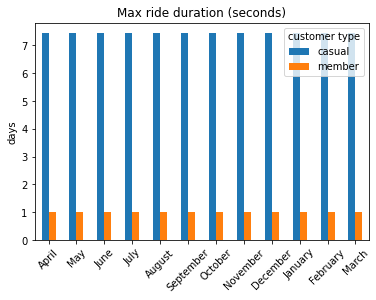

member_casual    casual    member             All
April          7.446505  1.024745 7 days 10:42:58
May            7.446505  1.024745 7 days 10:42:58
June           7.446505  1.024745 7 days 10:42:58
July           7.446505  1.024745 7 days 10:42:58
August         7.446505  1.024745 7 days 10:42:58
September      7.446505  1.024745 7 days 10:42:58
October        7.446505  1.024745 7 days 10:42:58
November       7.446505  1.024745 7 days 10:42:58
December       7.446505  1.024745 7 days 10:42:58
January        7.446505  1.024745 7 days 10:42:58
February       7.446505  1.024745 7 days 10:42:58
March          7.446505  1.024745 7 days 10:42:58


In [8]:
""" Analysis of the MAX ride duration over the year """

# Turns timedelta data into days (float)
year_max_days = year_max.copy()# makes a copy of the yearly table
for i in range(2): # converts each column of the timedelta data into days (float)
    data_td = year_max.iloc[:,i]
    data_float = (data_td.dt.days  # converts days
                + data_td.dt.seconds/24/3600 # converts hours, minutes, seconds
                )
    year_max_days.iloc[:,i] = data_float

# plots MAX duration vs month for members and casuals as bar graph
year_max_days.plot(kind="bar", y = ["casual","member"]
              , title="Max ride duration (seconds)"
               , rot=45)
plt.ylabel("days")
plt.legend(title = "customer type")
plt.show()
print(year_max_days) # prints the yearly MIN ride duration table

In [ ]:
""" Analysis of the MIN ride duration over the year """

# Turns timedelta data into seconds (float)
year_min_days = year_min.copy()# makes a copy of the yearly table
for i in range(2): # converts each column of the timedelta data into seconds (float)
    data_td = year_min.iloc[:,i]
    data_float = data_td.dt.seconds
    year_min_days.iloc[:,i] = data_float

# plots MIN duration vs month for members and casuals as bar graph
year_min_days.plot(kind="bar", y = ["casual","member"]
              , title="MIN ride duration (seconds)"
               , rot=45)
plt.ylabel("seconds")
plt.legend(title = "customer type")
plt.show()
print(year_min_days) # prints the yearly MIN ride duration table

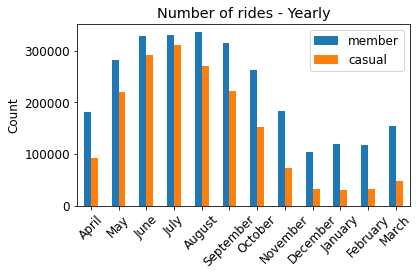

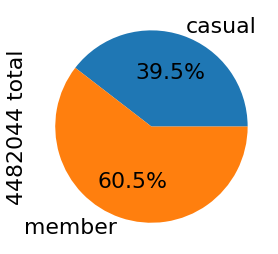

In [36]:
""" Analysis of the Count of rides over the year """

# Bar graph
# plots Count of rides vs month for members and casuals as bar graph
year_count.iloc[:,[0,1]].plot(
                            kind="bar"
                            , y = ["member","casual"]
                            , title = "Number of rides - Yearly"
                            , rot = 45) # X labels rotation
plt.ylabel("Count")
plt.legend(title = "")

plt.tight_layout() # fixes the layout
plt.savefig(save_folder + "Year_Number of rides" #saves the graph
            , dpi=300) # resolution
plt.show()

# Pie chart
# plots the yearly Count of rides for members and casuals as pie chart
count_total = year_count.sum(axis=0) # sums the monthly counts
plt.rcParams.update({'font.size': 22}) # changes the font size
count_total.iloc[0:2].plot(                    # plots the pie chart
                            kind="pie"         # type of chart
                           , autopct='%1.1f%%' # digits for the % values
                           , title="")         #title
plt.ylabel(str(count_total.iloc[2]) + " total", loc="center")
plt.tight_layout() # fixes the layout
plt.savefig(save_folder + "Year_Number of rides Pie" # saves the graph
            , dpi=300) # resolution
plt.show()
plt.rcParams.update({'font.size': 12}) # restore the font size to normal

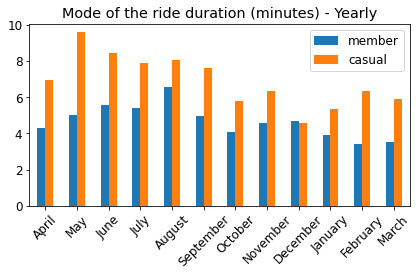

In [46]:
""" Analysis of the Mode of ride duration over the year """

year_mode_days = year_mode.copy() # makes a copy of the table
for i in range(3): # converts the timedelta columns into minutes (float)
    data_td = year_mode.iloc[:,i]
    data_float = data_td.dt.seconds/60
    year_mode_days.iloc[:,i] = data_float

# Bar chart
# plots Mode of ride duration vs month for members and casuals
year_mode_days.plot(kind="bar", y = ["member", "casual"]
              , title="Mode of the ride duration (minutes) - Yearly"
              , rot=45)
plt.ylabel("")
plt.legend(title = "")
plt.tight_layout() # fixes the layout
plt.savefig(save_folder + "Year_Mode of ride duration" # saves the graph
            , dpi=300) # resolution
plt.show()

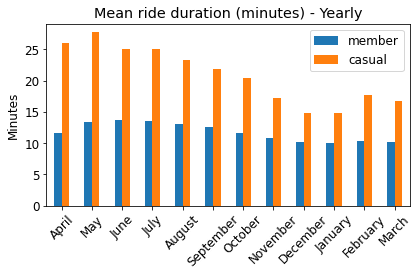

In [37]:
""" Analysis of the Mean ride duration over the year """

year_mean_days = year_mean.copy() # makes a copy of the table
for i in range(3): # converts the timedelta columns into minutes (float)
    data_td = year_mean.iloc[:,i]
    data_float = data_td.dt.seconds/60
    year_mean_days.iloc[:,i] = data_float

    
# Bar chart
# plots Mean ride duration vs month for members and casuals
year_mean_days.plot(kind="bar", y = ["member","casual"]
              , title="Mean ride duration (minutes) - Yearly"
              , rot=45)
plt.ylabel("Minutes")
plt.legend(title = "")
plt.tight_layout() # fixes the layout
plt.savefig(save_folder + "Year_Mean ride duration" # saves the graph
            , dpi = 300) # resolution
plt.show()

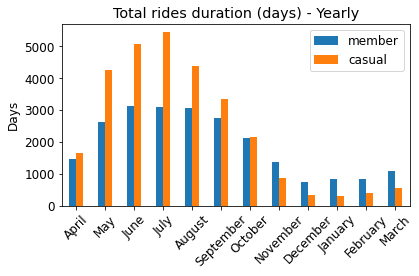

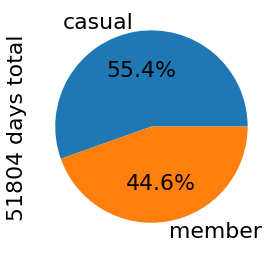

In [45]:
""" Analysis of the Total ride duration over the year """

year_sum_days = year_sum.copy() # makes a copy of the table
for i in range(3): # converts the timedelta columns into days (float)
    data_td = year_sum.iloc[:,i]
    data_float = data_td.dt.days + data_td.dt.seconds/3600/24
    year_sum_days.iloc[:,i] = data_float

# Bar chart
# plots Total ride duration vs month for members and casuals
year_sum_days.plot(kind="bar", y = ["member","casual"]
              , title="Total rides duration (days) - Yearly"
              , rot=45)
plt.ylabel("Days")
plt.legend(title = "")
plt.tight_layout() # fixes the layout
plt.savefig(save_folder + "Year_Total duration" # saves the graph
            , dpi = 300) # resolution
plt.show()

# Pie chart
# plots Total yearly ride duration for members and casuals
time_total = year_sum_days.sum(axis=0) # sums montly ride duration Total
plt.rcParams.update({'font.size': 22}) # changes global font size
time_total.iloc[0:2].plot( # plots the data
                            kind="pie" # type of plot
                            , autopct='%1.1f%%') # digits for the % values
plt.ylabel(str(int(time_total.iloc[2])) + " days total"
           , loc="center", fontsize = 22)
plt.tight_layout() # fixes the layout
plt.savefig(save_folder + "Year_Total duration Pie" # saves the chart
            , dpi = 300) # resolution
plt.show()
plt.rcParams.update({'font.size': 12}) # restores the font size to normal